In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 1

# 1. Set PYTHONHASHSEED environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
seed_value += 1

# 2. Set python built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
seed_value += 1

# 3. Set numpy pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
seed_value += 1

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import model_selection
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
import numpy as np 
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1 

A partir del fichero "US_Crime_Rates_1960_2014", se pide:

1. Tratar el dataset como una serie temporal a partir de la columna Year. Siempre el eje X será el nuevo índice Year.
2. Dibujar todas las columnas numéricas.
3. Como se puede ver en el punto 2, la columna "Population" tiene una magnitud diferente a la de las demás columnas: Dibuja la misma gráfica que antes pero con dos resoluciones diferentes para que se puedan observar con mejor detalle todas las columnas. 
4. A partir de ahora y para el resto del ejercicio, borra las columnas "Population" y "Total" ¿Qué columnas tienen mejor correlación? 
5. A partir de las cinco columnas que tengan mejor correlación con la columna "Murder", entrena un modelo de regresión no lineal a partir de polinomio de grado 6. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento.
6. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones=23 y n_repeats=7.

<AxesSubplot:xlabel='Year'>

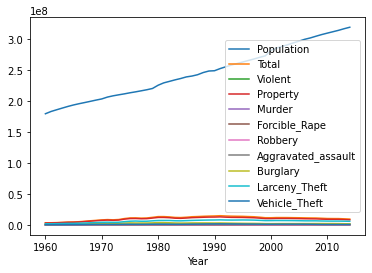

In [2]:
import pandas as pd
df = pd.read_csv("../data/US_Crime_Rates_1960_2014.csv")

df.set_index("Year", inplace=True)
df.plot()

In [3]:
df.head()

,Population,Total,Violent,Property,Murder,Forcible_Rape,Robbery,Aggravated_assault,Burglary,Larceny_Theft,Vehicle_Theft
Year,,,,,,,,,,,
1960,179323175,3384200,288460,3095700,9110,17190,107840,154320,912100,1855400,328200
1961,182992000,3488000,289390,3198600,8740,17220,106670,156760,949600,1913000,336000
1962,185771000,3752200,301510,3450700,8530,17550,110860,164570,994300,2089600,366800
1963,188483000,4109500,316970,3792500,8640,17650,116470,174210,1086400,2297800,408300
1964,191141000,4564600,364220,4200400,9360,21420,130390,203050,1213200,2514400,472800


In [4]:
# 2. Dibujar todas las columnas numéricas.

In [5]:
df.dtypes

Population            int64
Total                 int64
Violent               int64
Property              int64
Murder                int64
Forcible_Rape         int64
Robbery               int64
Aggravated_assault    int64
Burglary              int64
Larceny_Theft         int64
Vehicle_Theft         int64
dtype: object

<AxesSubplot:xlabel='Year'>

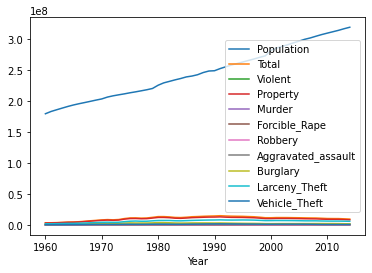

In [6]:
df.plot()

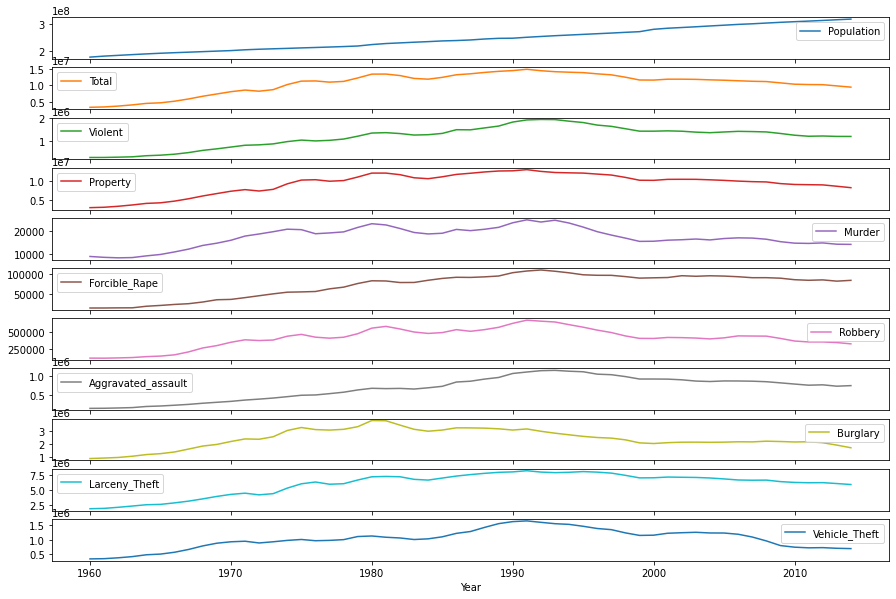

In [7]:
df.plot(subplots=True, figsize=(15,10))
plt.show()

In [8]:
# 3. Como se puede ver en el punto 2, la columna "Population" tiene una magnitud diferente a la de las demás columnas: Dibuja la misma gráfica que antes pero con dos resoluciones diferentes para que se puedan observar con mejor detalle todas las columnas.

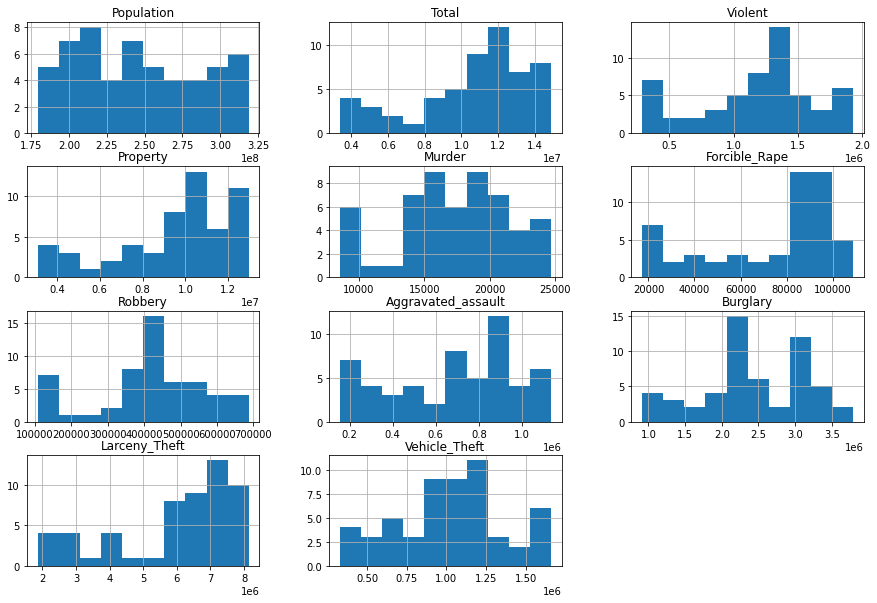

In [9]:
df.hist(figsize=(15,10))

plt.show()

In [10]:
# 4. A partir de ahora y para el resto del ejercicio, borra las columnas "Population" y "Total" ¿Qué columnas tienen mejor correlación?

In [11]:
df.drop(["Population", "Total"], axis=1, inplace=True)

In [12]:
correlation = df.corr()

sort_correlation = correlation.unstack().sort_values(ascending=False)
sort_correlation[sort_correlation < 1]

# Las columnas con mejor correlación son: 'violent' y 'aggravated_assault'


Violent             Aggravated_assault    0.981071
Aggravated_assault  Violent               0.981071
Property            Larceny_Theft         0.980528
Larceny_Theft       Property              0.980528
Violent             Larceny_Theft         0.974791
                                            ...   
                    Burglary              0.646607
Burglary            Forcible_Rape         0.588529
Forcible_Rape       Burglary              0.588529
Aggravated_assault  Burglary              0.498449
Burglary            Aggravated_assault    0.498449
Length: 72, dtype: float64

In [13]:
# 5. A partir de las cinco columnas que tengan mejor correlación con la columna "Murder", entrena un modelo de regresión no lineal a partir de polinomio de grado 6. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento.

In [14]:
correlation["Murder"].sort_values(ascending=False)[1:6]

Robbery          0.960156
Burglary         0.920207
Property         0.895641
Vehicle_Theft    0.856600
Larceny_Theft    0.806279
Name: Murder, dtype: float64

In [15]:
X = df[["Robbery", "Burglary", "Property", "Vehicle_Theft", "Larceny_Theft"]]
y = df["Murder"]

In [16]:
X = X.to_numpy()
y = y.to_numpy()

In [17]:
# convertimos los datos a np.int64 para intentar asegurar que los resultados sean iguales en cualquier ordenador
X.astype(np.int64)

array([[  107840,   912100,  3095700,   328200,  1855400],
       [  106670,   949600,  3198600,   336000,  1913000],
       [  110860,   994300,  3450700,   366800,  2089600],
       [  116470,  1086400,  3792500,   408300,  2297800],
       [  130390,  1213200,  4200400,   472800,  2514400],
       [  138690,  1282500,  4352000,   496900,  2572600],
       [  157990,  1410100,  4793300,   561200,  2822000],
       [  202910,  1632100,  5403500,   659800,  3111600],
       [  262840,  1858900,  6125200,   783600,  3482700],
       [  298850,  1981900,  6749000,   878500,  3888600],
       [  349860,  2205000,  7359200,   928400,  4225800],
       [  387700,  2399300,  7771700,   948200,  4424200],
       [  376290,  2375500,  7413900,   887200,  4151200],
       [  384220,  2565500,  7842200,   928800,  4347900],
       [  442400,  3039200,  9278700,   977100,  5262500],
       [  470500,  3265300, 10252700,  1009600,  5977700],
       [  427810,  3108700, 10345500,   966000,  6270800

In [18]:
y.astype(np.int64)

array([ 9110,  8740,  8530,  8640,  9360,  9960, 11040, 12240, 13800,
       14760, 16000, 17780, 18670, 19640, 20710, 20510, 18780, 19120,
       19560, 21460, 23040, 22520, 21010, 19310, 18690, 18980, 20613,
       20096, 20680, 21500, 23440, 24700, 23760, 24530, 23330, 21610,
       19650, 18208, 16914, 15522, 15586, 16037, 16229, 16528, 16148,
       16740, 17030, 16929, 16442, 15399, 14772, 14661, 14866, 14319,
       14249], dtype=int64)

In [19]:
# Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones=23 y n_repeats=7.

In [20]:
import random
import warnings
warnings.filterwarnings("ignore")

def score_func(degree, n_splits=23, n_repeats=7):
    """
    This funcion trains any polinominal model and returns its train & validation score, MAE and RMSE.

    Params: 
        Degree (int) of the polinominal model
        n_splits = repeatedKfold iteration
        n_repeats = repeatedKfold epoch
    """

    k_fold = RepeatedKFold(n_splits, n_repeats)

    val_score = []
    train_score = []
    train_MAE = []
    val_MAE = []
    train_RMSE = []
    val_RMSE = []

    polinominal_model = PolynomialFeatures(degree) 
    X_poly = polinominal_model.fit_transform(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2)

    lin_reg_model = LinearRegression()

    for i, (train, val) in enumerate(k_fold.split(X_train)):

        lin_reg_model.fit(X_train[train], y_train[train])
        score_val = lin_reg_model.score(X_train[val], y_train[val])

        predictions_train = lin_reg_model.predict(X_train[train])
        predictions_val = lin_reg_model.predict(X_train[val])

        train_MAE.append(mean_absolute_error(y_train[train], predictions_train))
        train_RMSE.append(np.sqrt(mean_squared_error(y_train[train], predictions_train)))
        val_MAE.append(mean_absolute_error(y_train[val], predictions_val))
        val_RMSE.append(np.sqrt(mean_squared_error(y_train[val], predictions_val)))

        val_score.append(score_val)
        score_train = lin_reg_model.score(X_train[train], y_train[train])
        train_score.append(score_train)

    dictionary = {"Train Score": train_score, "Validation Score": val_score, "MAE Train": train_MAE, "MAE Validation": val_MAE, "RMSE Train": train_RMSE, "RMSE Validation": val_RMSE} 
    scores = pd.DataFrame(dictionary)
    return scores, train_score, val_score

In [23]:
scores, train_score, val_score = score_func(degree=6, n_splits=23, n_repeats=7)
scores

,Train Score,Validation Score,MAE Train,MAE Validation,RMSE Train,RMSE Validation
0,1.0,-3.273907e+05,0.186007,5.981019e+05,0.216283,8.296633e+05
1,1.0,-8.000862e+03,0.055328,1.882890e+05,0.080009,2.147322e+05
2,1.0,-6.156487e+02,0.097912,5.613596e+04,0.116807,7.783720e+04
3,1.0,-1.197775e+06,0.169096,2.595888e+05,0.204115,2.637575e+05
4,1.0,5.639527e-02,0.000025,2.556935e+02,0.000035,2.817040e+02
...,...,...,...,...,...,...
156,1.0,-1.083323e+05,0.099353,5.325750e+05,0.133791,7.422114e+05
157,1.0,-6.542818e+06,0.093683,6.941976e+06,0.115658,9.359332e+06
158,1.0,-3.545054e+04,0.049856,5.071439e+05,0.061172,5.166562e+05
159,1.0,NaN,0.082043,1.861761e+06,0.096406,1.861761e+06


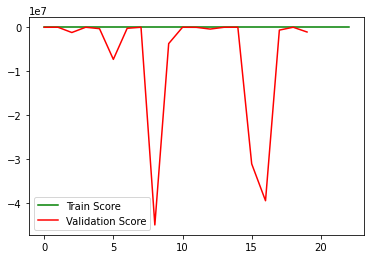

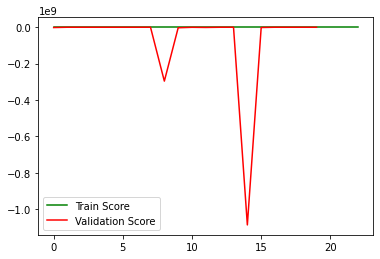

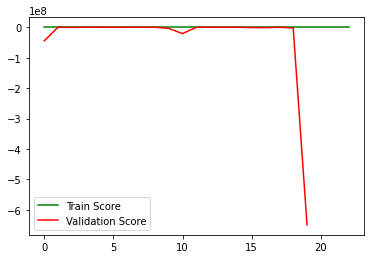

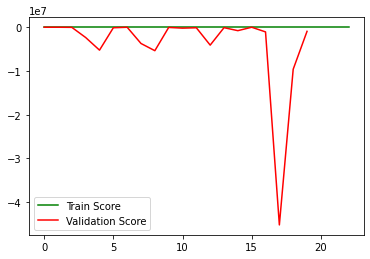

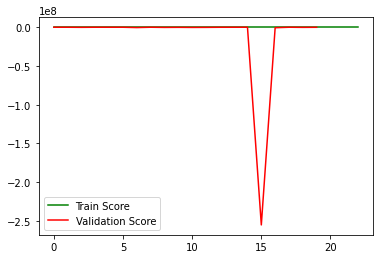

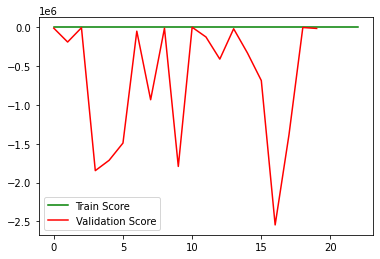

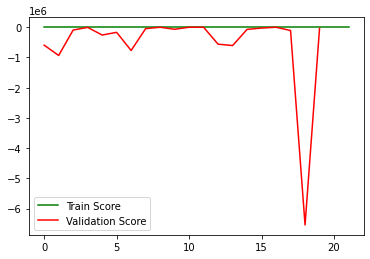

In [24]:
# Tenemos 7 epocas con 43 iteraciones, por lo que el rango va desde 1 a 161+1 con un step de 23
for i in range(1, 162, 23):
    fig, ax = plt.subplots()
    ax.plot(train_score[i:i+23], color="green", label="Train Score")
    ax.plot(val_score[i:i+23], color="red", label= "Validation Score")
    ax.legend(loc="best")

    plt.show()

In [ ]:
# En algunos puntos ha habido sobre-aprendizaje porque el validation score está por debajo del train score